In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
from simulation import minimal_model as mm
from surrogate import neural_network

from sampling import grid, random
from visualise import stream, surface

2024-05-06 21:38:14.013353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 21:38:14.765286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data generation

In [3]:
# Minimal model testing
g = 1.7
B_lim, D_lim = 2.9, 0.4

In [4]:
# RS = random.RandomStack()
# D_grid, B_grid = RS.sample_stack([(0, D_lim), (0, B_lim)], 100)

In [5]:
# Grid search
EG = grid.EqualStack()
D_grid, B_grid = EG.sample_stack([(0, D_lim), (0, B_lim)], 100)

In [6]:
# Run miminal model
dB_dt, dD_dt = mm.step(B_grid, D_grid, g, warm_up=0)

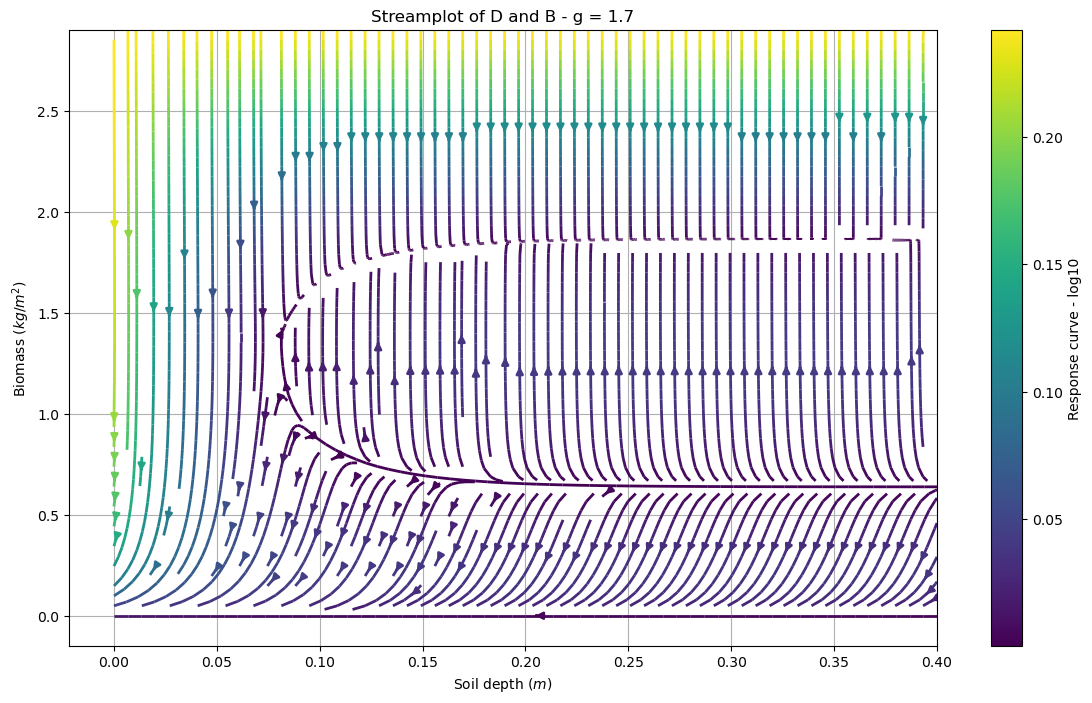

In [7]:
stream.show(D_grid, B_grid, dD_dt, dB_dt, g)

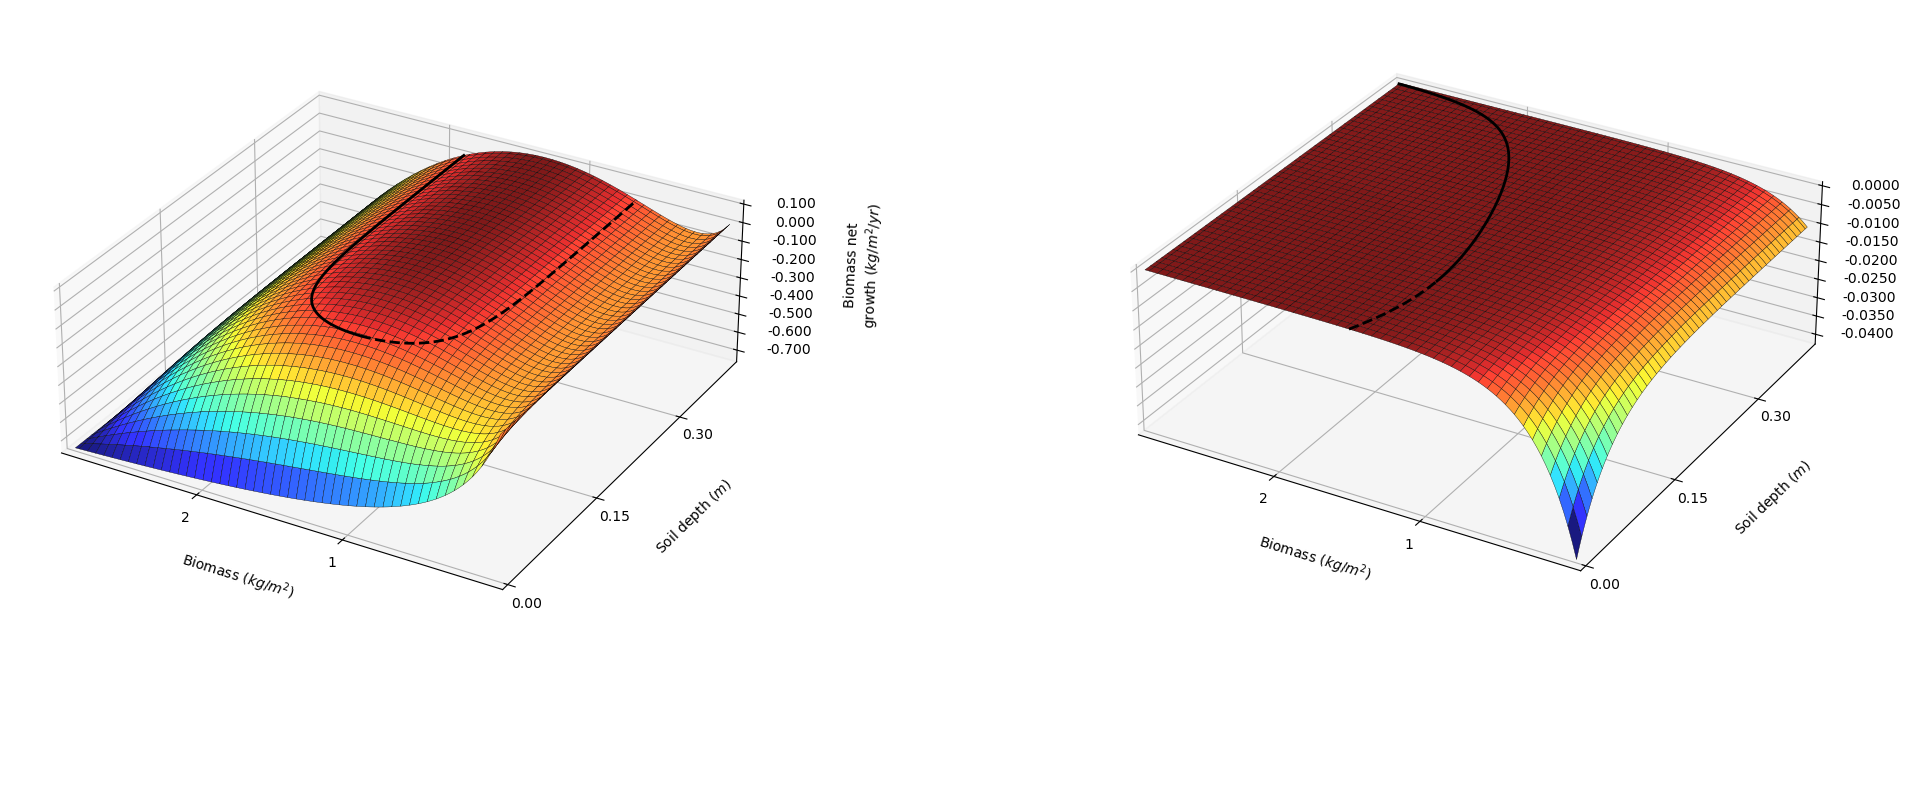

In [8]:
surface.show(D_grid, B_grid, dD_dt, dB_dt, D_lim, B_lim)

In [26]:
#  ['B', 'D', 'g', 'dB_dt', 'dD_dt']
X = np.column_stack([B_grid.flatten(), D_grid.flatten(), np.repeat(g, (100*100))])
y = np.column_stack([dB_dt.flatten(), dD_dt.flatten()])
X.shape, y.shape

((10000, 3), (10000, 2))

# Neural network

## Training

In [17]:
# NN = neural_network.NeuralNetwork(uid="20240506_1840")
NN = neural_network.NeuralNetwork()
NN.paths['model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

NN.train(X_train, y_train, X_val, y_val)

Starting Neural Network training...
Epoch 1/100


I0000 00:00:1715024442.943690    8453 service.cc:145] XLA service 0x6ffca80199b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715024442.943722    8453 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-06 21:40:43.041929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-06 21:40:43.511337: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715024445.108163    9297 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1760', 624 bytes spill stores, 624 bytes spill loads

I0000 00:00:1715024445.720357    9292 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1826', 772 bytes spill stores, 692 bytes spill loads

I0000 

1/2 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 1.3085

I0000 00:00:1715024462.141182    8453 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1715024464.877554    9880 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_841', 232 bytes spill stores, 232 bytes spill loads

I0000 00:00:1715024464.881188    9894 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1351', 704 bytes spill stores, 708 bytes spill loads

I0000 00:00:1715024465.067989    9887 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1782', 632 bytes spill stores, 564 bytes spill loads

I0000 00:00:1715024465.825653    9885 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1227', 60 bytes spill stores, 72 bytes spill loads

I0000 00:00:1715024465.931663    9889 asm_compiler.cc:369] ptxa

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - loss: 1.3348 

I0000 00:00:1715024483.295890   10565 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_202', 216 bytes spill stores, 216 bytes spill loads

I0000 00:00:1715024483.353805   10572 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1715024483.428190   10574 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 700 bytes spill stores, 700 bytes spill loads

I0000 00:00:1715024484.510529   10563 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_184', 576 bytes spill stores, 576 bytes spill loads

I0000 00:00:1715024484.599291   10575 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_202', 232 bytes spill stores, 232 bytes spill loads

I0000 00:00:1715024484.7076

2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 27s/step - loss: 1.3435 - val_loss: 1.4369
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3619 - val_loss: 1.3971
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3367 - val_loss: 1.3441
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3170 - val_loss: 1.3520
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3048 - val_loss: 1.4043
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3536 - val_loss: 1.3883
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3240 - val_loss: 1.3611
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3075 - val_loss: 1.3461
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2981 - val_loss: 1.3671
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3113 - val_loss: 1.3442
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2925 - val_loss: 1.3454
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2909 - val_loss: 1.3517
E

In [18]:
# import json
# uid = NN.uid
# with open(f"data/history/{uid}.json", "r") as f:
#     history = json.load(f)
# history.keys()

In [19]:
# plt.title(f"Training history\n\nLR: {NN.hp['learning_rate']}, BS: {NN.hp['batch_size']}")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.plot(history['loss'], label="Loss")
# plt.plot(history['val_loss'], label="Val Loss")
# plt.legend()
# plt.show()

## Predition

In [27]:
# B_true, D_true = EG.sample_stack([(0, D_lim), (0, B_lim)], 100)
# X = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (100*100))))

dB_dt, dD_dt = mm.step(B_grid, D_grid, g, warm_up=0)
Y = np.column_stack((dB_dt.flatten(), dD_dt.flatten()))
X.shape, Y.shape

((10000, 3), (10000, 2))

In [28]:
y_pred = NN.model.predict(X)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


In [29]:
mean_squared_error(Y, y_pred)

0.03311789419281668

In [30]:
pred_dB_dt, pred_dD_dt,  = y_pred.reshape(2, 100, 100)

In [31]:
D_grid.shape, B_grid.shape, pred_dD_dt.shape, pred_dB_dt.shape

((100, 100), (100, 100), (100, 100), (100, 100))

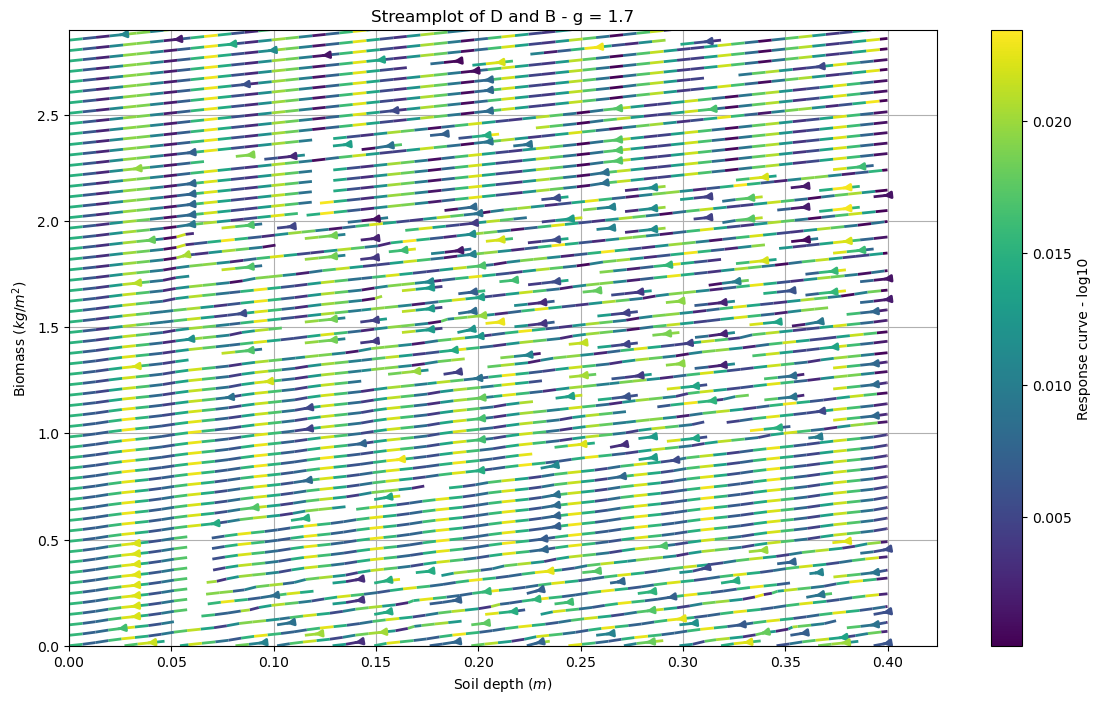

In [32]:
stream.show(D_grid, B_grid, pred_dD_dt, pred_dB_dt, g)